In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Preparing camera and dataset

In [2]:
def get_rays(datapath, mode='train'):
    
    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)
    
    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))
    
    images = []
    
    for i in range(N):
        name = pose_file_names[i]
        
        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)
        
        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)
        
        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)
    
    H = images.shape[1]
    W = images.shape[2]
    
    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))
    
    for i in range(N):
        
        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
        
        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values


## Volumetrix Rendering

In [3]:
def compute_accumulated_transmittance(betas):
    """
    Computes the accumulated transmittance given a tensor of betas

    Args:
        betas (torch.Tensor): A tensor of shape (batch_size, num_layers) containing the betas for each layer

    Returns:
        torch.Tensor: A tensor of shape (batch_size, num_layers) containing the accumulated transmittance for each layer
    """
    accumulated_transmittance = torch.cumprod(betas, 1)
    return torch.cat(
        (
            torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
            accumulated_transmittance[:, :-1]
        ),
        dim=1
    )

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu', white_bckgr=True):
    """
    Renders an image of a 3D scene using volumetric rendering.

    Args:
    - model: a model that predicts the color and density at each point in space
    - rays_o: the origin of the rays, shape [nb_rays, 3]
    - rays_d: the direction of the rays, shape [nb_rays, 3]
    - tn: the near clipping distance, a float
    - tf: the far clipping distance, a float
    - nb_bins: the number of bins to discretize the rays with, an integer
    - device: the device to run the computation on, a string
    - white_bckgr: whether to assume a white background, a boolean

    Returns:
    - c: the rendered image, shape [nb_rays, 3]
    """

    # Discretize the rays
    t = torch.linspace(tn, tf, nb_bins).to(device)  # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)  # [nb_rays, nb_bins, 3]    

    # Query the model for the colors and density along the rays
    colors, density = model.intersect(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3))
    colors = colors.reshape((x.shape[0], nb_bins, 3))  # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))

    # Compute the accumulated transmittance and the weights
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0))  # [nb_rays, nb_bins, 1]
    weights = compute_accumulated_transmittance(1 - alpha) * alpha  # [nb_rays, nb_bins]

    # Compute the final color
    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1)  # [nb_rays, 3]
        weight_sum = weights.sum(-1)  # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1)  # [nb_rays, 3]
        return c


## Voxel model

In [4]:
import torch
import torch.nn as nn

class Voxels(nn.Module):

    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        """
        Constructor for the Voxels class.

        Args:
            nb_voxels (int): Number of voxels per dimension.
            scale (float): Scaling factor for the voxels.
            device (str): Device to store the voxels on.
        """
        super(Voxels, self).__init__()

        # Initialize the voxels randomly and make it a parameter of the module
        self.voxels = torch.nn.Parameter(torch.rand(
            (nb_voxels, nb_voxels, nb_voxels, 4), device=device, requires_grad=True))

        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale

    def forward(self, xyz, d):
        """
        Forward pass of the VoxelFeatureExtractor module.

        Args:
            xyz: A tensor of shape (N, 3) representing the coordinates of the points.
            d: A tensor of shape (N, C) representing the features of the points.

        Returns:
            A tuple of two tensors. The first tensor is of shape (N, 3) representing the RGB values of the voxels. 
            The second tensor is of shape (N, 1) representing the density values of the voxels.
        """

        # Split the coordinates of the points into x, y, and z
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]

        # Create a boolean tensor indicating which points are inside the voxel grid
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))

        # Compute the indices of the voxels containing the points
        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)

        # Initialize a tensor to store the RGB values and density values of the voxels
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)

        # Copy the RGB values and density values of the voxels containing the points
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1]

        # Apply the sigmoid function to the RGB values and the ReLU function to the density values
        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])

    def intersect(self, x, d):
        return self.forward(x, d)


In [5]:
from tqdm import tqdm

def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device='cpu'):
    
    training_loss = []
    for epoch in (range(nb_epochs)):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)
            
            target = batch[:, 6:].to(device)
            
            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)
            
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            
        scheduler.step()
        
        torch.save(model.cpu(), 'model_voxels')
        model.to(device)
        
    return training_loss

In [6]:
batch_size = 1024

o, d, target_px_values = get_rays('/content/drive/MyDrive/dev/NeRF/fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3),
                                   torch.from_numpy(d).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('/content/drive/MyDrive/dev/NeRF/fox', mode='test')

<ipython-input-2-c69b9c1e21df>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


In [7]:
device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

Training on GPU


100%|██████████| 3516/3516 [00:36<00:00, 95.39it/s] 


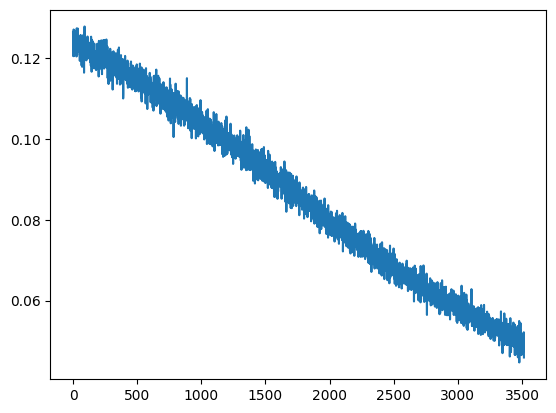

100%|██████████| 14063/14063 [02:04<00:00, 112.82it/s]


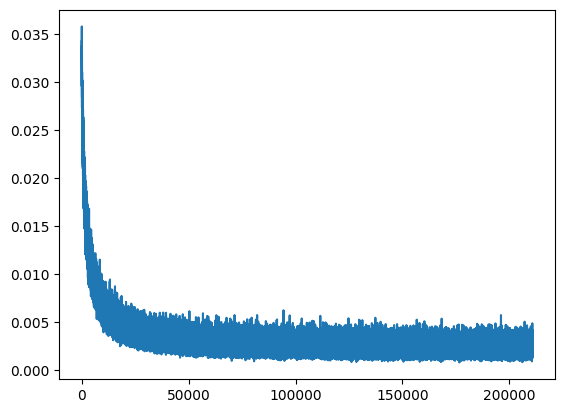

In [8]:
tn = 8
tf = 12
nb_epochs = 15
lr = 1e-3
gamma = .5
nb_bins = 100

model = Voxels(scale=3, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

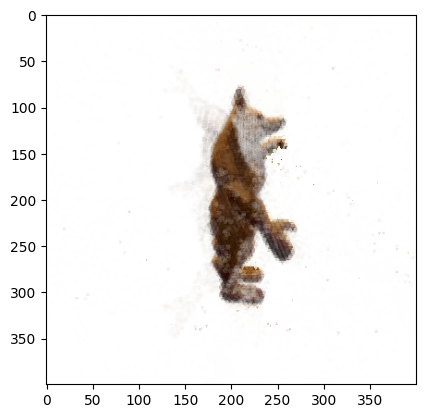

In [10]:
img = rendering(model, torch.from_numpy(o[0]).to(device), torch.from_numpy(d[0]).to(device), 
                tn, tf, nb_bins=100, device=device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())